In [1]:
import cv2, dlib, math
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
from torchinfo import summary
%matplotlib inline

In [3]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.0.1+cpu'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
import torchinfo

In [6]:
from pathlib import Path

In [7]:
image_path = Path("data2/")
if image_path.is_dir():
    print(f'{image_path} directory exists')
else:
    print(f"찾을 수 없음")

data2 directory exists


In [8]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [9]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data2'.
There are 0 directories and 782 images in 'data2\cool'.
There are 0 directories and 788 images in 'data2\warm'.


In [15]:
face_dir = image_path
face_dir

WindowsPath('data2')

## 사진 확인하기

Random image path: data2\warm\ec4a168b4c46f7b1c1b7811f1f5ca6a2.jpg
Image class: warm
Image height: 258
Image width: 258


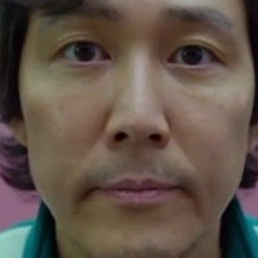

In [18]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*.jpg"))
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

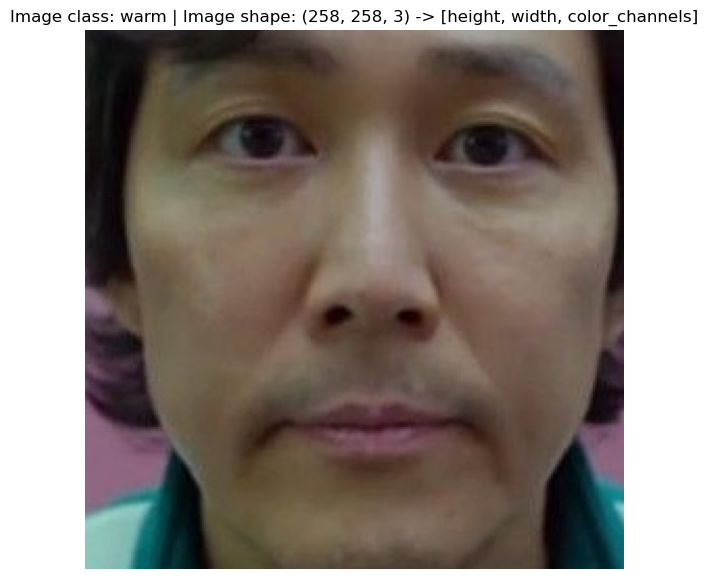

In [19]:
# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [20]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 이미지폴더 이용해 데이터세트 만들기

In [21]:
def dataset_info(data_dir):
    data_transform = transforms.Compose([
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor() 
    ])
    
    dataset = datasets.ImageFolder(root=data_dir,
                                   transform=data_transform,
                                   target_transform=None) # 라벨 변환시 사용
    print("데이터 정보: \n", dataset)


In [22]:
dataset_info(face_dir)

데이터 정보: 
 Dataset ImageFolder
    Number of datapoints: 1570
    Root location: data2
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [23]:
from torch.utils.data.sampler import SubsetRandomSampler

In [24]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
        data_dir: str,
        transform: transforms.Compose,
        batch_size: int,
        num_workers: int=NUM_WORKERS
):
        dataset = datasets.ImageFolder(data_dir,
                                   transform=transform,
                                   target_transform=None)

        np.random.seed(42)
        valid_size = 0.3
        num_train = len(dataset)
        indices = list(range(num_train))
        np.random.shuffle(indices)
        split = int(np.floor(valid_size * num_train))
        train_idx, valid_idx = indices[split:], indices[:split]

        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        # load training data in batches
        train_loader = torch.utils.data.DataLoader(dataset,
                                                batch_size=batch_size,
                                                sampler=train_sampler,
                                                num_workers=num_workers)

        # load validation data in batches
        valid_loader = torch.utils.data.DataLoader(dataset,
                                                batch_size=batch_size,
                                                sampler=valid_sampler,
                                                num_workers=num_workers)

        return dataset, train_loader, valid_loader


In [25]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [28]:
dataset, train_loader, valid_loader = create_dataloaders(data_dir=face_dir, transform=preprocess, batch_size=32)

print('train 데이터세트 크기:', len(dataset))
class_names = dataset.classes
print('클래스:', class_names)


train 데이터세트 크기: 1570
클래스: ['cool', 'warm']


## 모바일넷 

In [29]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\user\anaconda3\envs\tmyc\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\tmyc\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [30]:
# 베이스 레이어 고정시키기
for param in model.features.parameters():
    param.requires_grad = False

In [31]:
output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), # 과적합을 막기 위해 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape,
                    bias=True)).to(device)

In [32]:
summary(model, 
        input_size=(32, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [32, 3, 256, 256]    [32, 2]              --                   Partial
├─Sequential (features)                       [32, 3, 256, 256]    [32, 1280, 8, 8]     --                   False
│    └─Conv2dNormActivation (0)               [32, 3, 256, 256]    [32, 32, 128, 128]   --                   False
│    │    └─Conv2d (0)                        [32, 3, 256, 256]    [32, 32, 128, 128]   (864)                False
│    │    └─BatchNorm2d (1)                   [32, 32, 128, 128]   [32, 32, 128, 128]   (64)                 False
│    │    └─ReLU6 (2)                         [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─InvertedResidual (1)                   [32, 32, 128, 128]   [32, 16, 128, 128]   --                   False
│    │    └─Sequential (conv)                 [32, 32, 128, 128]   [32, 16, 1

## 트레이닝

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
from service import engine

c:\Users\user\anaconda3\envs\tmyc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_loader,
                       test_dataloader=valid_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  2%|▏         | 1/50 [01:39<1:21:38, 99.98s/it]

Epoch: 1 | train_loss: 0.6081 | train_acc: 0.6769 | test_loss: 0.6641 | test_acc: 0.6139


  4%|▍         | 2/50 [03:29<1:24:39, 105.82s/it]

Epoch: 2 | train_loss: 0.6011 | train_acc: 0.6826 | test_loss: 0.6768 | test_acc: 0.5877


  6%|▌         | 3/50 [05:15<1:22:39, 105.51s/it]

Epoch: 3 | train_loss: 0.6051 | train_acc: 0.6653 | test_loss: 0.6659 | test_acc: 0.6168


  8%|▊         | 4/50 [07:08<1:23:21, 108.73s/it]

Epoch: 4 | train_loss: 0.6044 | train_acc: 0.6628 | test_loss: 0.6812 | test_acc: 0.5923


 10%|█         | 5/50 [09:04<1:23:20, 111.13s/it]

Epoch: 5 | train_loss: 0.6152 | train_acc: 0.6630 | test_loss: 0.6882 | test_acc: 0.5814


 12%|█▏        | 6/50 [10:52<1:20:48, 110.18s/it]

Epoch: 6 | train_loss: 0.5989 | train_acc: 0.6805 | test_loss: 0.7749 | test_acc: 0.5639


 14%|█▍        | 7/50 [12:48<1:20:23, 112.18s/it]

Epoch: 7 | train_loss: 0.6000 | train_acc: 0.6555 | test_loss: 0.6711 | test_acc: 0.6090


 16%|█▌        | 8/50 [14:44<1:19:18, 113.30s/it]

Epoch: 8 | train_loss: 0.5955 | train_acc: 0.6886 | test_loss: 0.6810 | test_acc: 0.6014


 18%|█▊        | 9/50 [16:37<1:17:18, 113.14s/it]

Epoch: 9 | train_loss: 0.5863 | train_acc: 0.7015 | test_loss: 0.6687 | test_acc: 0.6272


 20%|██        | 10/50 [18:34<1:16:16, 114.41s/it]

Epoch: 10 | train_loss: 0.5793 | train_acc: 0.7030 | test_loss: 0.6918 | test_acc: 0.6053


 22%|██▏       | 11/50 [20:29<1:14:31, 114.66s/it]

Epoch: 11 | train_loss: 0.5769 | train_acc: 0.7038 | test_loss: 0.6859 | test_acc: 0.6101


 24%|██▍       | 12/50 [22:23<1:12:32, 114.54s/it]

Epoch: 12 | train_loss: 0.6057 | train_acc: 0.6636 | test_loss: 0.7112 | test_acc: 0.5826


 26%|██▌       | 13/50 [24:08<1:08:41, 111.40s/it]

Epoch: 13 | train_loss: 0.5752 | train_acc: 0.6897 | test_loss: 0.6991 | test_acc: 0.5977


 28%|██▊       | 14/50 [25:46<1:04:27, 107.43s/it]

Epoch: 14 | train_loss: 0.6184 | train_acc: 0.6620 | test_loss: 0.7134 | test_acc: 0.6052


 30%|███       | 15/50 [27:33<1:02:33, 107.25s/it]

Epoch: 15 | train_loss: 0.5916 | train_acc: 0.6921 | test_loss: 0.6753 | test_acc: 0.5973


 32%|███▏      | 16/50 [29:19<1:00:39, 107.05s/it]

Epoch: 16 | train_loss: 0.5621 | train_acc: 0.7075 | test_loss: 0.6993 | test_acc: 0.6093


 34%|███▍      | 17/50 [30:53<56:41, 103.08s/it]  

Epoch: 17 | train_loss: 0.5511 | train_acc: 0.7072 | test_loss: 0.6888 | test_acc: 0.5981


 36%|███▌      | 18/50 [32:34<54:34, 102.33s/it]

Epoch: 18 | train_loss: 0.5732 | train_acc: 0.7005 | test_loss: 0.6782 | test_acc: 0.6060


 38%|███▊      | 19/50 [34:17<53:01, 102.64s/it]

Epoch: 19 | train_loss: 0.5422 | train_acc: 0.7101 | test_loss: 0.6842 | test_acc: 0.6189


 40%|████      | 20/50 [35:57<50:55, 101.86s/it]

Epoch: 20 | train_loss: 0.5542 | train_acc: 0.7181 | test_loss: 0.6730 | test_acc: 0.6281


 42%|████▏     | 21/50 [37:39<49:17, 101.98s/it]

Epoch: 21 | train_loss: 0.5409 | train_acc: 0.7252 | test_loss: 0.6923 | test_acc: 0.6185


 44%|████▍     | 22/50 [39:13<46:24, 99.46s/it] 

Epoch: 22 | train_loss: 0.5588 | train_acc: 0.7045 | test_loss: 0.7170 | test_acc: 0.6052


 46%|████▌     | 23/50 [41:11<47:16, 105.06s/it]

Epoch: 23 | train_loss: 0.5462 | train_acc: 0.7243 | test_loss: 0.7022 | test_acc: 0.6085


 48%|████▊     | 24/50 [43:09<47:14, 109.02s/it]

Epoch: 24 | train_loss: 0.5559 | train_acc: 0.7110 | test_loss: 0.6939 | test_acc: 0.6052


 50%|█████     | 25/50 [45:01<45:47, 109.90s/it]

Epoch: 25 | train_loss: 0.5765 | train_acc: 0.7063 | test_loss: 0.6776 | test_acc: 0.6072


 52%|█████▏    | 26/50 [47:08<45:57, 114.88s/it]

Epoch: 26 | train_loss: 0.5427 | train_acc: 0.7350 | test_loss: 0.6923 | test_acc: 0.6002


 54%|█████▍    | 27/50 [49:09<44:48, 116.91s/it]

Epoch: 27 | train_loss: 0.5578 | train_acc: 0.7118 | test_loss: 0.7444 | test_acc: 0.5631


 56%|█████▌    | 28/50 [50:59<42:00, 114.59s/it]

Epoch: 28 | train_loss: 0.5608 | train_acc: 0.7030 | test_loss: 0.7241 | test_acc: 0.6180


 58%|█████▊    | 29/50 [52:35<38:14, 109.27s/it]

Epoch: 29 | train_loss: 0.5421 | train_acc: 0.7360 | test_loss: 0.6893 | test_acc: 0.6177


 60%|██████    | 30/50 [54:03<34:13, 102.70s/it]

Epoch: 30 | train_loss: 0.5410 | train_acc: 0.7217 | test_loss: 0.7233 | test_acc: 0.6130


 60%|██████    | 30/50 [54:11<36:07, 108.37s/it]


KeyboardInterrupt: 

In [ ]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
plot_loss_curves(results)